In [1]:
# Martin Konečnik, https://git.siwim.si/machine-learning/fix-qa-binary-classification
# Notebook intended for prototyping binary classification models
import gc
import pickle
import random
import tomllib
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from swm import factory
from torch.utils.data import DataLoader, TensorDataset

# Initialize CUDA.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
# Read the configuration file.
with open('conf.toml', 'rb') as f:
    conf = tomllib.load(f)

EVENTS_PATH = Path().home() / conf['data_dir'] / 'prepared'
FIRST_CHANNEL = conf['first_channel']
LAST_CHANNEL = conf['last_channel']
LOAD_EVENTS = conf.get('load_events', False)

In [3]:
# TODO Feels like signals_unaltered and signals_corrected should be np arrays, but cba changing that now.
unaltered_pkl_path = EVENTS_PATH / 'unaltered.pkl'
corrected_pkl_path = EVENTS_PATH / 'corrected.pkl'
if LOAD_EVENTS or not unaltered_pkl_path.exists() or not corrected_pkl_path.exists():  # To save time event files are only read if pkl files don't exist or if explicitly set in the toml file.
    # Read the event files.
    signals_unaltered = [[] for _ in range(FIRST_CHANNEL, LAST_CHANNEL + 1)]  # Initializes an empty list for each channel.
    signals_corrected = [[] for _ in range(FIRST_CHANNEL, LAST_CHANNEL + 1)]
    binary_labels = []
    for event in (EVENTS_PATH / 'unaltered' / '0').iterdir():
        data = factory.read_file(event)
        for ch in range(FIRST_CHANNEL, LAST_CHANNEL + 1):
            signals_unaltered[ch].append(data.acqdata.a[ch].data)
    with open(unaltered_pkl_path, 'wb') as f:
        pickle.dump(signals_unaltered, f)

    for event in (EVENTS_PATH / 'corrected' / '0').iterdir():
        data = factory.read_file(event)
        for ch in range(FIRST_CHANNEL, LAST_CHANNEL + 1):
            signals_corrected[ch].append(data.acqdata.a[ch].data)
    with open(corrected_pkl_path, 'wb') as f:
        pickle.dump(signals_corrected, f)
else:
    # Read the pickled arrays.
    with open(unaltered_pkl_path, 'rb') as f:
        signals_unaltered = pickle.load(f)
    with open(corrected_pkl_path, 'rb') as f:
        signals_corrected = pickle.load(f)

print(f'Number of channels: {len(signals_unaltered)}.')
print(f'Unaltered signals: {len(signals_unaltered[0])}.')
print(f'Corrected signals: {len(signals_corrected[0])}.')

Number of channels: 8.
Unaltered signals: 60309.
Corrected signals: 1192.


In [4]:
def splice(my_list: List[float], index: int, signal_length: int) -> Tuple[np.array, np.array]:
    """
    Split signals into two arrays.
    :param my_list: List of signals to be processed.
    :param index: Index on which the lists are split.
    :param signal_length: Maximum length of a signal.
    :return:
    """
    result = [[] for _ in range(len(my_list))]
    print(f'Processing {len(my_list)} channels ...')
    for i, veh in enumerate(my_list):
        print(f'Processing {len(veh)} signals for channel {i} ...')
        for signal in veh:  # Normalize the signals.
            result[i].append(np.pad(signal - signal[0], (0, signal_length - len(signal))))
    return np.array([sublist[:index] for sublist in result]), np.array([sublist[index:] for sublist in result])


# Split signals into training and testing sets.
num_signals = len(signals_unaltered)
max_length = max(len(signal) for signal in signals_unaltered[0] + signals_corrected[0])

signals_unaltered, test_unaltered = splice(signals_unaltered, -200, max_length)
signals_corrected, test_corrected = splice(signals_corrected, -100, max_length)

num_samples = len(signals_corrected[0])  # This value represents the number of samples for each class.
print(f'Number of signals: {num_signals}.')
print(f'Max length: {max_length}.')
print(f'Number of samples: {num_samples}.')

Processing 8 channels ...
Processing 60309 signals for channel 0 ...
Processing 60309 signals for channel 1 ...
Processing 60309 signals for channel 2 ...
Processing 60309 signals for channel 3 ...
Processing 60309 signals for channel 4 ...
Processing 60309 signals for channel 5 ...
Processing 60309 signals for channel 6 ...
Processing 60309 signals for channel 7 ...
Processing 8 channels ...
Processing 1192 signals for channel 0 ...
Processing 1192 signals for channel 1 ...
Processing 1192 signals for channel 2 ...
Processing 1192 signals for channel 3 ...
Processing 1192 signals for channel 4 ...
Processing 1192 signals for channel 5 ...
Processing 1192 signals for channel 6 ...
Processing 1192 signals for channel 7 ...
Number of signals: 8.
Max length: 4329.
Number of samples: 1092.


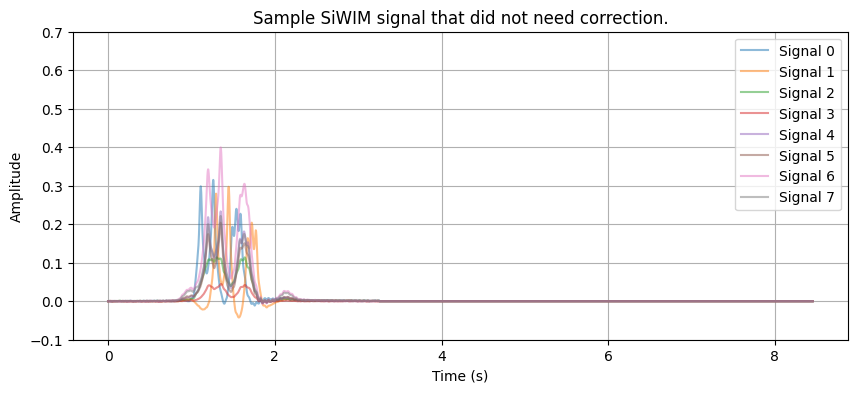

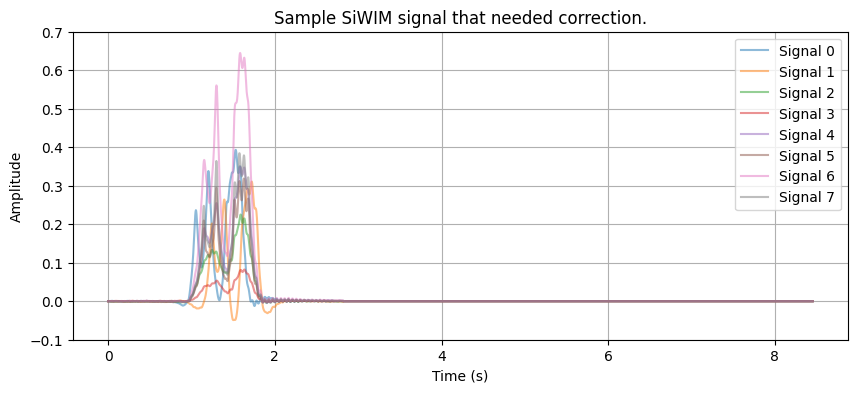

In [5]:
# Sample signal
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(num_signals):
    plt.plot(np.arange(max_length) / 512, signals_unaltered[i][0], label=f'Signal {i}', alpha=0.5)
plt.title('Sample SiWIM signal that did not need correction.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-0.1, 0.7)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
for i in range(num_signals):
    plt.plot(np.arange(max_length) / 512, signals_corrected[i][2], label=f'Signal {i}', alpha=0.5)
plt.title('Sample SiWIM signal that needed correction.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-0.1, 0.7)
plt.grid(True)
plt.legend()
plt.show()

In [6]:
chosen_signal = 6

print(f'Corrected shape: {signals_corrected.shape}')
print(f'Unaltered shape: {signals_unaltered.shape}')

samples = random.sample(range(len(signals_unaltered[chosen_signal])), num_samples)  # Get a list of 1000 random unaltered samples.
signals = np.vstack((np.empty((num_samples, max_length)), signals_corrected[chosen_signal]))

print(f'Signals shape: {signals.shape}')

count = 0
for i, sample in enumerate(samples):
    signals[i] = signals_unaltered[chosen_signal][sample]

binary_labels = np.array([0] * num_samples + [1] * num_samples)
print(f'Binary labels shape: {binary_labels.shape}')  # Must be 1D.

del signals_unaltered, signals_corrected

Corrected shape: (8, 1092, 4329)
Unaltered shape: (8, 60109, 4329)
[45085, 2689, 57893, 30685, 33331, 42946, 14056, 37391, 36499, 45630, 10910, 9416, 25164, 3876, 5237, 23022, 17805, 53613, 10076, 3225, 19505, 50352, 56392, 58068, 44472, 51120, 28869, 36655, 1448, 19994, 16270, 7384, 30731, 24560, 9885, 20790, 59004, 7267, 9732, 30797, 24976, 41476, 54020, 11050, 45130, 38000, 33453, 20629, 10226, 34404, 59549, 18150, 45303, 24956, 13568, 50499, 57200, 6628, 3868, 17280, 12994, 34112, 49926, 20034, 19675, 54439, 5771, 30697, 27564, 18431, 24814, 58924, 18263, 3776, 12968, 16095, 58988, 47027, 19828, 51726, 33402, 36600, 40242, 56010, 1099, 59102, 31028, 12118, 38370, 42384, 42202, 36470, 13871, 26329, 57262, 52849, 26139, 57032, 7100, 48984, 19413, 24653, 12279, 59867, 22513, 23671, 10294, 23732, 59793, 56744, 10064, 9076, 5944, 50625, 57867, 29394, 24212, 24693, 26372, 9603, 47155, 25899, 30703, 47131, 8175, 55362, 42070, 414, 4258, 33300, 26912, 44395, 32277, 42847, 23697, 1507, 4395

In [7]:
# First, create indices array
indices = np.arange(len(signals))

# Split indices into train/validation
train_idx, val_idx = train_test_split(
    indices,  # Split the indices
    test_size=0.2,
    random_state=42  # Always set random state for reproducibility
)

X_tensor = torch.from_numpy(signals).unsqueeze(1).to(device)  # Unsqueeze is done to ensure tensor dimensions are correct for conv1d to work properly.
y_tensor = torch.from_numpy(binary_labels).to(device)
print('X_tensor shape:', X_tensor.shape)
print('y_tensor shape:', y_tensor.shape)

# Create dataset
full_dataset = TensorDataset(X_tensor, y_tensor)
print('Dataset defined.')

# Create train/test datasets using the indices we split earlier
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
print('Train dataset built.')

val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
print('Validation dataset built.')

X_tensor shape: torch.Size([2184, 1, 4329])
y_tensor shape: torch.Size([2184])
Dataset defined.
Train dataset built.
Validation dataset built.


In [8]:
print('=== DEBUGGING ===')
print(f'X_tensor dim: {X_tensor.dim()}, shape: {X_tensor.shape}')
print(f'y_tensor shape: {y_tensor.shape}')

# Test without unsqueeze first
test_dataset = TensorDataset(X_tensor, y_tensor)
test_loader = DataLoader(test_dataset, batch_size=2)
test_batch = next(iter(test_loader))
print(f'Raw batch X shape: {test_batch[0].shape}')
print(f'Raw batch y shape: {test_batch[1].shape}')

# Now test with your unsqueeze approach
X_test_unsqueeze = X_tensor.unsqueeze(1)
test_dataset2 = TensorDataset(X_test_unsqueeze, y_tensor)
test_loader2 = DataLoader(test_dataset2, batch_size=2)
test_batch2 = next(iter(test_loader2))
print(f'With unsqueeze X shape: {test_batch2[0].shape}')

# Clean up no longer used data.
del full_dataset, val_idx, train_idx, X_tensor, y_tensor

=== DEBUGGING ===
X_tensor dim: 3, shape: torch.Size([2184, 1, 4329])
y_tensor shape: torch.Size([2184])
Raw batch X shape: torch.Size([2, 1, 4329])
Raw batch y shape: torch.Size([2])
With unsqueeze X shape: torch.Size([2, 1, 1, 4329])


In [9]:
torch.cuda.empty_cache()
gc.collect()

torch.multiprocessing.set_start_method('spawn', force=True)

# Prepare DataLoaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
print('Train Loader created.')
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)
print('Val Loader created')

# Sanity check
sample_X, sample_y = next(iter(train_loader))
print(f'Final training batch - X shape: {sample_X.shape}, y shape: {sample_y.shape}')
print(f'X dtype: {sample_X.dtype}, y dtype: {sample_y.dtype}')  # Should be float32 and int.

del val_dataset, train_dataset

Train Loader created.
Val Loader created
Final training batch - X shape: torch.Size([32, 1, 4329]), y shape: torch.Size([32])
X dtype: torch.float64, y dtype: torch.int64


In [10]:
# Initialize model, loss function and optimizer.
from classifier import BinaryClassifier

model = BinaryClassifier(max_length).to(device)
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [11]:
torch.cuda.empty_cache()
gc.collect()

num_epochs = 20
loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float()).squeeze()  # Make outputs same dimensions as labels.
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  # Update loss.
    loss_list.append(running_loss / len(train_loader))

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}')

Epoch 1, Loss: 0.6940
Epoch 2, Loss: 0.6929
Epoch 3, Loss: 0.6902
Epoch 4, Loss: 0.6913
Epoch 5, Loss: 0.6870
Epoch 6, Loss: 0.6864
Epoch 7, Loss: 0.6829
Epoch 8, Loss: 0.6740
Epoch 9, Loss: 0.6624
Epoch 10, Loss: 0.6506
Epoch 11, Loss: 0.6304
Epoch 12, Loss: 0.6171
Epoch 13, Loss: 0.6041
Epoch 14, Loss: 0.5954
Epoch 15, Loss: 0.5744
Epoch 16, Loss: 0.5712
Epoch 17, Loss: 0.5591
Epoch 18, Loss: 0.5453
Epoch 19, Loss: 0.5658
Epoch 20, Loss: 0.5423


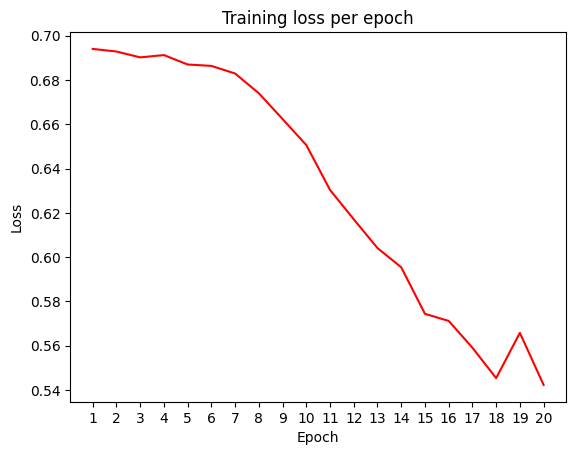

In [12]:
plt.plot(range(1, num_epochs + 1), np.array(loss_list), 'r')
plt.title('Training loss per epoch')
plt.xlabel('Epoch')
plt.xticks(range(1, num_epochs + 1))
plt.ylabel('Loss')
plt.show()

In [13]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        outputs = model(inputs.float())
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 71.40%


In [14]:
from cestel_helpers.version import get_version

ver = get_version()

model_path = Path(f'models/{ver}')
model_path.mkdir(exist_ok=True, parents=True)

# Save model
torch.save(model.state_dict(), model_path / 'fix-qa-binary-classification.pth')

# Save dimensions
with open(model_path / 'dimensions', 'w') as f:
    f.write(str(max_length))